In [1]:
import os
import warnings
import numpy as np

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

import matplotlib  as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches

from matplotlib.patches import Rectangle
from radical.analytics.utils import to_latex

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
! radical-stack # the runs associated with this notebook used old RCT stack, so make sure to be consistent


  python               : /home/aymen/ve/impress/bin/python3
  pythonpath           : 
  version              : 3.12.3
  virtualenv           : /home/aymen/ve/impress

  radical.analytics    : 1.61.0
  radical.entk         : 1.62.0
  radical.gtod         : 1.61.0
  radical.pilot        : 1.61.0
  radical.utils        : 1.61.0



In [4]:
!rm -rf ~/.radical/analytics/cache

fonts_dir = os.path.join(os.getcwd(), 'fonts')
# see: https://github.com/radical-cybertools/tutorials/tree/main/src/devel

if os.path.isdir(fonts_dir):
    try:
        fm.fontManager.addfont(fm.findSystemFonts(fonts_dir)[0])

        plt.style.use(ra.get_mplstyle('radical_mpl'))
        mpl.rcParams['text.usetex'] = False
        mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']
        mpl.rcParams['font.family'] = 'serif'
    except Exception as e:
        print(f'WARNING: font is not set ({e})')
else:
    print('WARNING: directory with font(s) not found')

# Get session tracing events

Enter session ID to collect its events:

In [5]:
sid = 'sessions/adap8/rp.session.gpu005.amarel.rutgers.edu.ja961.020026.0000'

In [6]:
session = ra.Session(sid, 'radical.pilot')

In [7]:
data = {'session': session,
        'pilot'  : session.filter(etype='pilot', inplace=False).get()[0],
        'tasks'  : session.filter(etype='task',  inplace=False)}

data['sid'] = sid
data['pid'] = data['pilot'].uid
data['smt'] = os.environ.get('RADICAL_SMT') or \
              data['pilot'].cfg['resource_details']['rm_info']['threads_per_core']

for t in data['tasks'].get():
    print(t.uid, t.name)

p1.1.000000 T1.initial.mpnn.run
p2.1.000000 T1.initial.mpnn.run
p1.2.000000 T2.make.fasta.NHERF3
p1.2.000001 T2.make.fasta.HTRA1
p2.2.000000 T2.make.fasta.SCRIB
p2.2.000001 T2.make.fasta.SHANK1
p1.3.000000 T3.af2.passes.NHERF32
p1.3.000001 T3.af2.passes.HTRA12
p2.3.000000 T3.af2.passes.SCRIB2
p2.3.000001 T3.af2.passes.SHANK12
p2.4.000000 T4.peptides.passes.2
p1.4.000000 T4.peptides.passes.2
p2.5.000000 T5.mpnn.passes.2
p1.5.000000 T5.mpnn.passes.2
p2.6.000000 T6.make.fasta.SCRIB
p2.6.000001 T6.make.fasta.SHANK1
p1.6.000000 T6.make.fasta.NHERF3
p1.6.000001 T6.make.fasta.HTRA1
p2.3.000002 T3.af2.passes.SCRIB3
p2.3.000003 T3.af2.passes.SHANK13
p2.4.000001 T4.peptides.passes.3
p1.3.000002 T3.af2.passes.NHERF33
p1.3.000003 T3.af2.passes.HTRA13
p2.5.000001 T5.mpnn.passes.3
p1.4.000001 T4.peptides.passes.3
p2.6.000002 T6.make.fasta.SCRIB
p2.6.000003 T6.make.fasta.SHANK1
p1.5.000001 T5.mpnn.passes.3
p2.3.000004 T3.af2.passes.SCRIB4
p2.3.000005 T3.af2.passes.SHANK14
p1.6.000002 T6.make.fasta.NH

In [8]:
def run_metrics(data, ntasks=None):
    ttx = data['tasks'].duration(event=[{ru.EVENT: 'task_run_start'},
                                        {ru.EVENT: 'task_run_stop'}])
    runtime = data['pilot'].duration(event=[{ru.EVENT: 'bootstrap_0_start'},
                                            {ru.EVENT: 'bootstrap_0_stop'}])
    print(f'TOTAL RUNTIME: {round(runtime)}s | RCT OVH: {round(runtime - ttx)}s')
    
    if ntasks and ntasks > 1:
        task_idx = ntasks - 1
        print(f'# Following rates are based on the first {ntasks} tasks')
    else:
        task_idx = -1
        ntasks = None
        print(f'# Following rates are based on all tasks')

    # calculate scheduling throughput (for the first N tasks or for all tasks)
    ts_schedule_ok = sorted(session.timestamps(event={ru.STATE: 'AGENT_SCHEDULING'}))
    total_tasks = ntasks or len(ts_schedule_ok)
    print('scheduling rate: ', total_tasks / (ts_schedule_ok[task_idx] - ts_schedule_ok[0]))

    # calculate launching rate (for the first N tasks or for all tasks)
    ts_agent_executing = sorted(session.timestamps(event=[{ru.EVENT: 'launch_submit'}]))
    total_tasks = ntasks or len(ts_agent_executing)
    print('launching rate: ', total_tasks / (ts_agent_executing[task_idx] - ts_agent_executing[0]))

In [9]:
try:
    run_metrics(data, ntasks=None)
except Exception as e:
    print(e)

TOTAL RUNTIME: 139371s | RCT OVH: 45s
# Following rates are based on all tasks
scheduling rate:  0.0005526997183340753
launching rate:  0.0005526993710401883


# Resource Utilization

In [10]:
def generate_color_shades(n, base_color="Greens"):
    """Generates n shades of green."""
    base = {'Greens': plt.cm.Greens,
            'Blues': plt.cm.Blues}
    colors = [mcolors.to_hex(base[base_color](i / (n+1))) for i in range(1, n+1)]
    return colors

In [11]:
def plot_utilization(data, resources=None, save=False, with_metrics=False):

    DURATIONS = {
        'boot'        : [{ru.EVENT: 'bootstrap_0_start'},
                         {ru.EVENT: 'bootstrap_0_ok'   }],
        'agent_setup' : [{ru.EVENT: 'bootstrap_0_ok'   },
                         {ru.STATE: rp.PMGR_ACTIVE     }],
        'exec_queue'  : [{ru.STATE: rp.AGENT_SCHEDULING},
                         {ru.STATE: rp.AGENT_EXECUTING }],
        'exec_prep'   : [{ru.STATE: rp.AGENT_EXECUTING },
                         {ru.EVENT: 'task_run_start'   }],
        'exec_rp'     : [{ru.EVENT: 'task_run_start'   },
                         {ru.EVENT: 'launch_start'     }],
        'exec_sh'     : [{ru.EVENT: 'launch_start'     },
                         {ru.EVENT: 'launch_submit'    }],
        'exec_launch' : [{ru.EVENT: 'launch_submit'    },
                         {ru.EVENT: 'exec_start'       }],
        'exec_cmd'    : [{ru.EVENT: 'exec_start'       },
                         {ru.EVENT: 'exec_stop'        }],
        'exec_finish' : [{ru.EVENT: 'exec_stop'        },
                         {ru.EVENT: 'launch_collect'   }],
        'term_sh'     : [{ru.EVENT: 'launch_collect'   },
                         {ru.EVENT: 'launch_stop'      }],
        'term_rp'     : [{ru.EVENT: 'launch_stop'      },
                         {ru.EVENT: 'task_run_stop'    }],
        'unschedule'  : [{ru.EVENT: 'task_run_stop'    },
                         {ru.EVENT: 'unschedule_stop'  }]
    }

    
    METRICS = [
        ['Bootstrap',     ['boot', 'agent_setup'],        '#c6dbef'],
        #['Warmup',        ['warm'],                       '#f0f0f0'],
        ['Schedule',      ['exec_queue', 'unschedule'],   '#c994c7'],
        ['Prep',          ['exec_prep', 'exec_rp', 'exec_sh',
                           'term_sh', 'term_rp'],         '#fdbb84'],
        #['Launch method', ['exec_launch', 'exec_finish'], '#ff9999'],
        ['Launch',        ['exec_launch'],                '#ff9999'],
        ['Running',       ['exec_cmd'],                   '#88bb88'],  # color to be updated
        #['Cooldown',      ['drain'],                      '#addd8e']
    ]
    
    
    correction = 0.5
    sid = data['sid']
    pid = data['pid']
    
    rtypes = ru.as_list(resources) or ['cpu', 'gpu']
    rtype_info = {'cpu': {'label': 'Number of CPU cores',
                          'formatter': lambda z, pos: int(z / data['smt'])},
                  'gpu': {'label': 'Number of GPUs',
                          'formatter': None}}
    
    # fig, axarr = plt.subplots(1, len(rtypes), figsize=(
    #     ra.get_plotsize(256 * len(rtypes), subplots=(1, len(rtypes)))))
    fig, axarr = plt.subplots(len(rtypes), 1, figsize=(7, 2 * len(rtypes)))
    
    exp = ra.Experiment([data['session']], stype='radical.pilot')
    # get the start time of each pilot
    p_zeros = ra.get_pilots_zeros(exp)
    
    # --- filter tasks per pipeline and color state RUNNING per pipeline ---
    
    p_tasks = {}  # tasks per pipeline
    for task in data['tasks'].get():
        pipeline_uid = task.description['uid'].split('.')[0]
        p_tasks.setdefault(pipeline_uid, []).append(task.uid)

    # green color with darker shades
    '''
    M_COLOR_RUNNING =[
    "#FF6F61",  # Coral
    "#6B5B95",  # Purple
    "#88B04B",  # Olive Green
    "#F7CAC9",  # Light Pink
    "#92A8D1",  # Light Blue
    "#955251",  # Burgundy
    "#B565A7",  # Lavender
    "#009B77",  # Teal
    "#FFB400",  # Golden Yellow
    "#FF6F20",  # Pumpkin Orange
    "#2C3E50",  # Midnight Blue
    "#D3D3D3"   # Light Gray
    ]
    '''
    M_COLOR_RUNNING = generate_color_shades(len(p_tasks)) 

    # --- ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ---

    legend = None
    for idx, rtype in enumerate(rtypes):
        
        if len(rtypes) > 1:
            ax = axarr[idx]
        else:
            ax = axarr
        
        x_min, x_max, y_min, y_max = None, None, None, None


        # make sure to sort the p_tasks based on the pipeline id (i.e, ascending)
        p_tasks = {key: p_tasks[key] for key in sorted(p_tasks, key=lambda x: int(x[1:]))}
        
        for idx, (p_uid, task_uids) in enumerate(p_tasks.items()):
            print(p_uid)
            p_session = data['session'].filter(uid=task_uids + [pid], inplace=False)
        
            consumed = rp.utils.get_consumed_resources(
                p_session, rtype, {'consume': DURATIONS})
        
            # Create a local copy of METRICS for this pipeline
            local_metrics = [list(metric) for metric in METRICS]
            local_metrics[-1][-1] = M_COLOR_RUNNING[idx]  # Assign unique color for "Running"
        
            # Generate the subplot with labels
            sid = sid.split('/')[-1]
        
            legend, patches, x, y = ra.get_plot_utilization(
                local_metrics, {sid: consumed}, p_zeros[sid][pid], sid)
        
            # Place all the patches on the axes
            for patch in patches:
                patch.set_y(patch.get_y() + correction)
                ax.add_patch(patch)
        
            x_min = x['min'] if not x_min else min(x_min, x['min'])
            x_max = x['max'] if not x_max else max(x_max, x['max'])
            y_min = y['min'] if not y_min else min(y_min, y['min'])
            y_max = y['max'] if not y_max else max(y_max, y['max'])

        ax.set_xlim([x_min, int(x_max)])
        ax.set_ylim([y_min + correction, int(y_max + correction)])

        ax.xaxis.set_major_locator(mticker.MaxNLocator(4))
        ax.yaxis.set_major_locator(mticker.MaxNLocator(4))

        if rtype_info[rtype]['formatter'] is not None:
            ax.yaxis.set_major_formatter(mticker.FuncFormatter(
                rtype_info[rtype]['formatter']))

        ax.set_ylabel(to_latex(rtype_info[rtype]['label']), fontsize=11)
        ax.set_title(' ')  # placeholder

    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)

    fig.legend(legend, [m[0] for m in METRICS],
               loc='upper center',
               #bbox_to_anchor=(0.5, 0.95),
               ncol=len(METRICS)) 

    legend_handles = [
        mpatches.Patch(color=M_COLOR_RUNNING[idx], label=f"{p_uid}") 
        for idx, p_uid in enumerate(p_tasks.keys())
    ]
    
    # Add the secondary legend for the color-ID association
    secondary_legend = plt.legend(handles=legend_handles,
                                  title="Running Pipeline IDs",
                                  bbox_to_anchor=(1, 2.2), ncol=4, frameon=True)
    ax.add_artist(secondary_legend)

    plt.tight_layout()
    plt.show()
    
    plot_name = '%s.ru.png' % '.'.join(sid.rsplit('.', 2)[1:])
    fig.savefig(plot_name)
    
    if with_metrics:
        # print resource utilization metrics
        for rtype in rtypes:
            _, _, stats_abs, stats_rel, info = data['session'].utilization(
                METRICS, rtype, {'consume': DURATIONS})
            print('%s RU: ' % rtype.upper(), info)

p1
p2
p3
p4
p5
p6
p7
p8
p9
p1
p2
p3
p4
p5
p6
p7
p8
p9


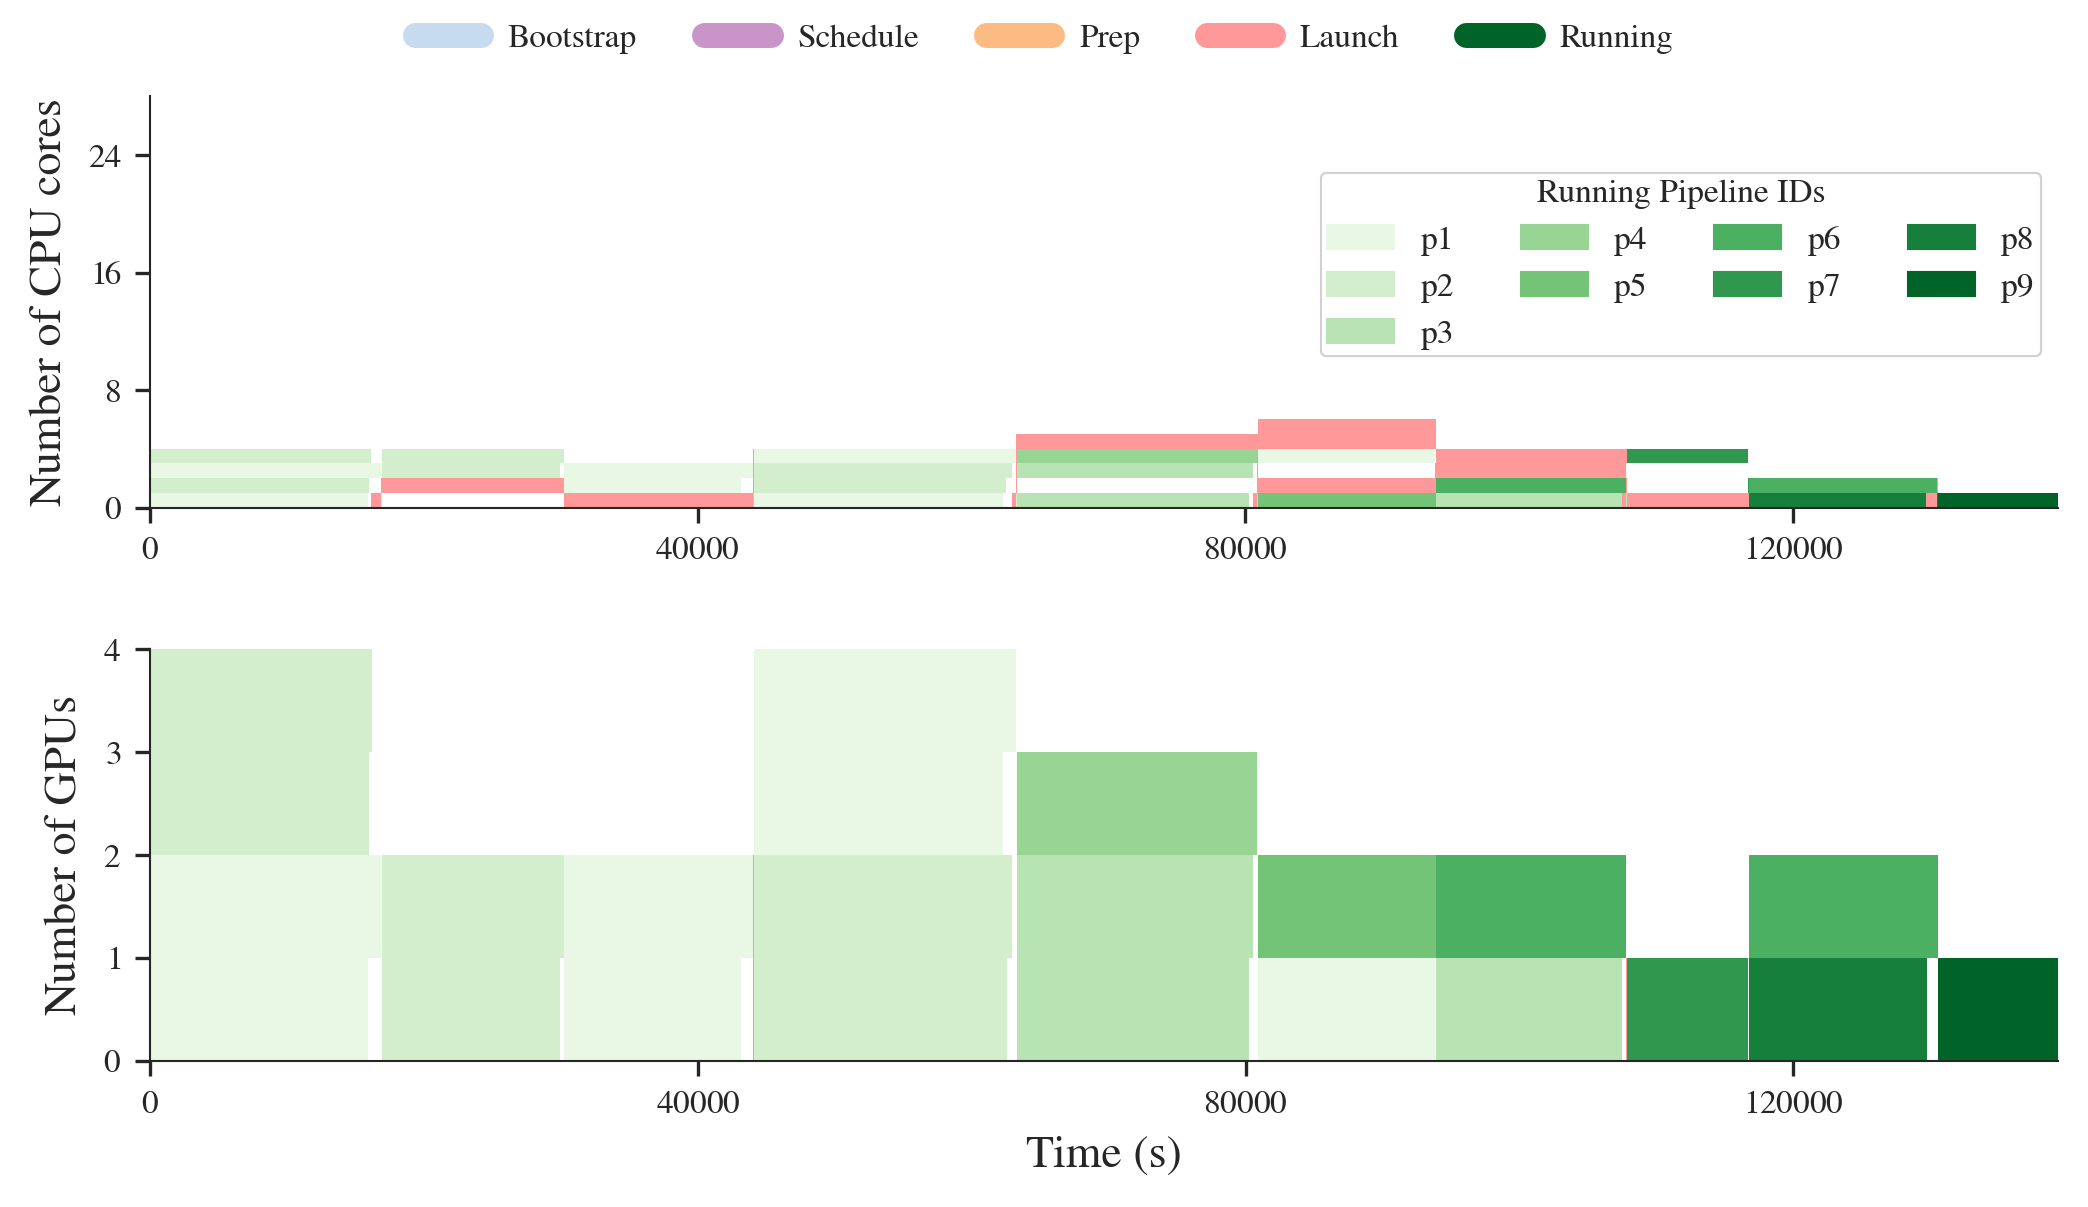

In [12]:
plot_utilization(data, resources=['cpu', 'gpu'], save=True, with_metrics=False)

# Resource Utilization - STACKED

In [13]:
def plot_utilization_stack(data, resources=None, save=False):

    tmap = {
        'pilot':  [
            [{1: 'bootstrap_0_start'}     , 'system'     , 'Bootstrap'  ],
            [{5: 'PMGR_ACTIVE'}           , 'Bootstrap'  , 'Idle'       ],
            [{1: 'cmd', 6: 'cancel_pilot'}, 'Idle'       , 'Term'       ],
            [{1: 'bootstrap_0_stop'}      , 'Term'       , 'system'     ],
            [{1: 'sub_agent_start'}       , 'Idle'       , 'agent'      ],
            [{1: 'sub_agent_stop'}        , 'agent'      , 'Term'       ]
        ],
        'task': [
            [{1: 'schedule_ok'}           , 'Idle'       , 'Exec setup' ],
            [{1: 'exec_start'}            , 'Exec setup' , 'Running'    ],
            [{1: 'exec_stop'}             , 'Running'    , 'Exec setup' ],
            [{1: 'unschedule_stop'}       , 'Exec setup' , 'Idle'       ]
        ],
    }
    metrics = [ 
        # metric,      line color, alpha, fill color, alpha
        ['Bootstrap',  ['#c6dbef', 0.0, '#c6dbef', 1]],
        ['Exec setup', ['#fdbb84', 0.0, '#fdbb84', 1]],
        ['Running',    ['#88bb88', 0.0, '#88bb88', 1]],
        ['Idle',       ['#f0f0f0', 0.0, '#f0f0f0', 1]]
    ]

    to_stack = [m[0] for m in metrics]
    to_plot = {m[0]: m[1] for m in metrics}
    
    sid = data['sid']
    pid = data['pid']
    
    rtypes = ru.as_list(resources) or ['cpu', 'gpu']
    fig, axarr = plt.subplots(len(rtypes), 1, figsize=(7, 2 * len(rtypes)))

    patches = []
    legend = []

    
    p_resrc, series, x = ra.get_pilot_series(
        data['session'], data['pilot'], tmap, rtypes, True)

    for idx, rtype in enumerate(rtypes):
        
        if len(rtypes) > 1:
            ax = axarr[idx]
        else:
            ax = axarr

        # stack timeseries for each metrics into areas
        areas = ra.stack_transitions(series, rtype, to_stack)

        # plot individual metrics
        prev_m = None
        for m in areas:

            if m not in to_plot:
                if m != 'time':
                    print('skip', m)
                continue

            lcol = to_plot[m][0]
            lalpha = to_plot[m][1]
            pcol = to_plot[m][2]
            palpha = to_plot[m][3]

            # plot the (stacked) areas
            ax.step(np.array(areas['time']), np.array(areas[m]),
                    where='post', label=m,
                    color=lcol, alpha=lalpha, linewidth=1.0)

            # fill first metric toward 0, all others towards previous line
            if not prev_m:
                patch = ax.fill_between(
                    areas['time'], areas[m],
                    step='post', label=m,
                    linewidth=0.0,
                    color=pcol, alpha=palpha)

            else:
                patch = ax.fill_between(
                    areas['time'], areas[m],
                    areas[prev_m],
                    step='post', label=m,
                    linewidth=0.0,
                    color=pcol, alpha=palpha)

            # remember patches for legend
            if len(legend) < len(metrics):
                legend.append(m)
                patches.append(patch)

            # remember this line to fill against
            prev_m = m

        ax.set_xlim([x['min'], x['max']])
        ax.set_ylim([0, 110])

        ax.yaxis.set_major_locator(
            mticker.MaxNLocator(3, steps=[5, 10]))

        ax.set_ylabel('%s (%%)' % rtype.upper(), fontsize=12)

        for ax in fig.get_axes():
            ax.label_outer()

    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)

    fig.legend(patches, legend, 
               loc='upper center',
               #bbox_to_anchor=(0.5, 1.01),
               ncol=len(metrics),
               fancybox=True, shadow=True, fontsize=11)

    plt.tight_layout()
    plt.show()

    if save:
        plot_name = '%s.ru.stack.png' % '.'.join(sid.rsplit('.', 2)[1:])
        fig.savefig(os.path.join('.', plot_name))

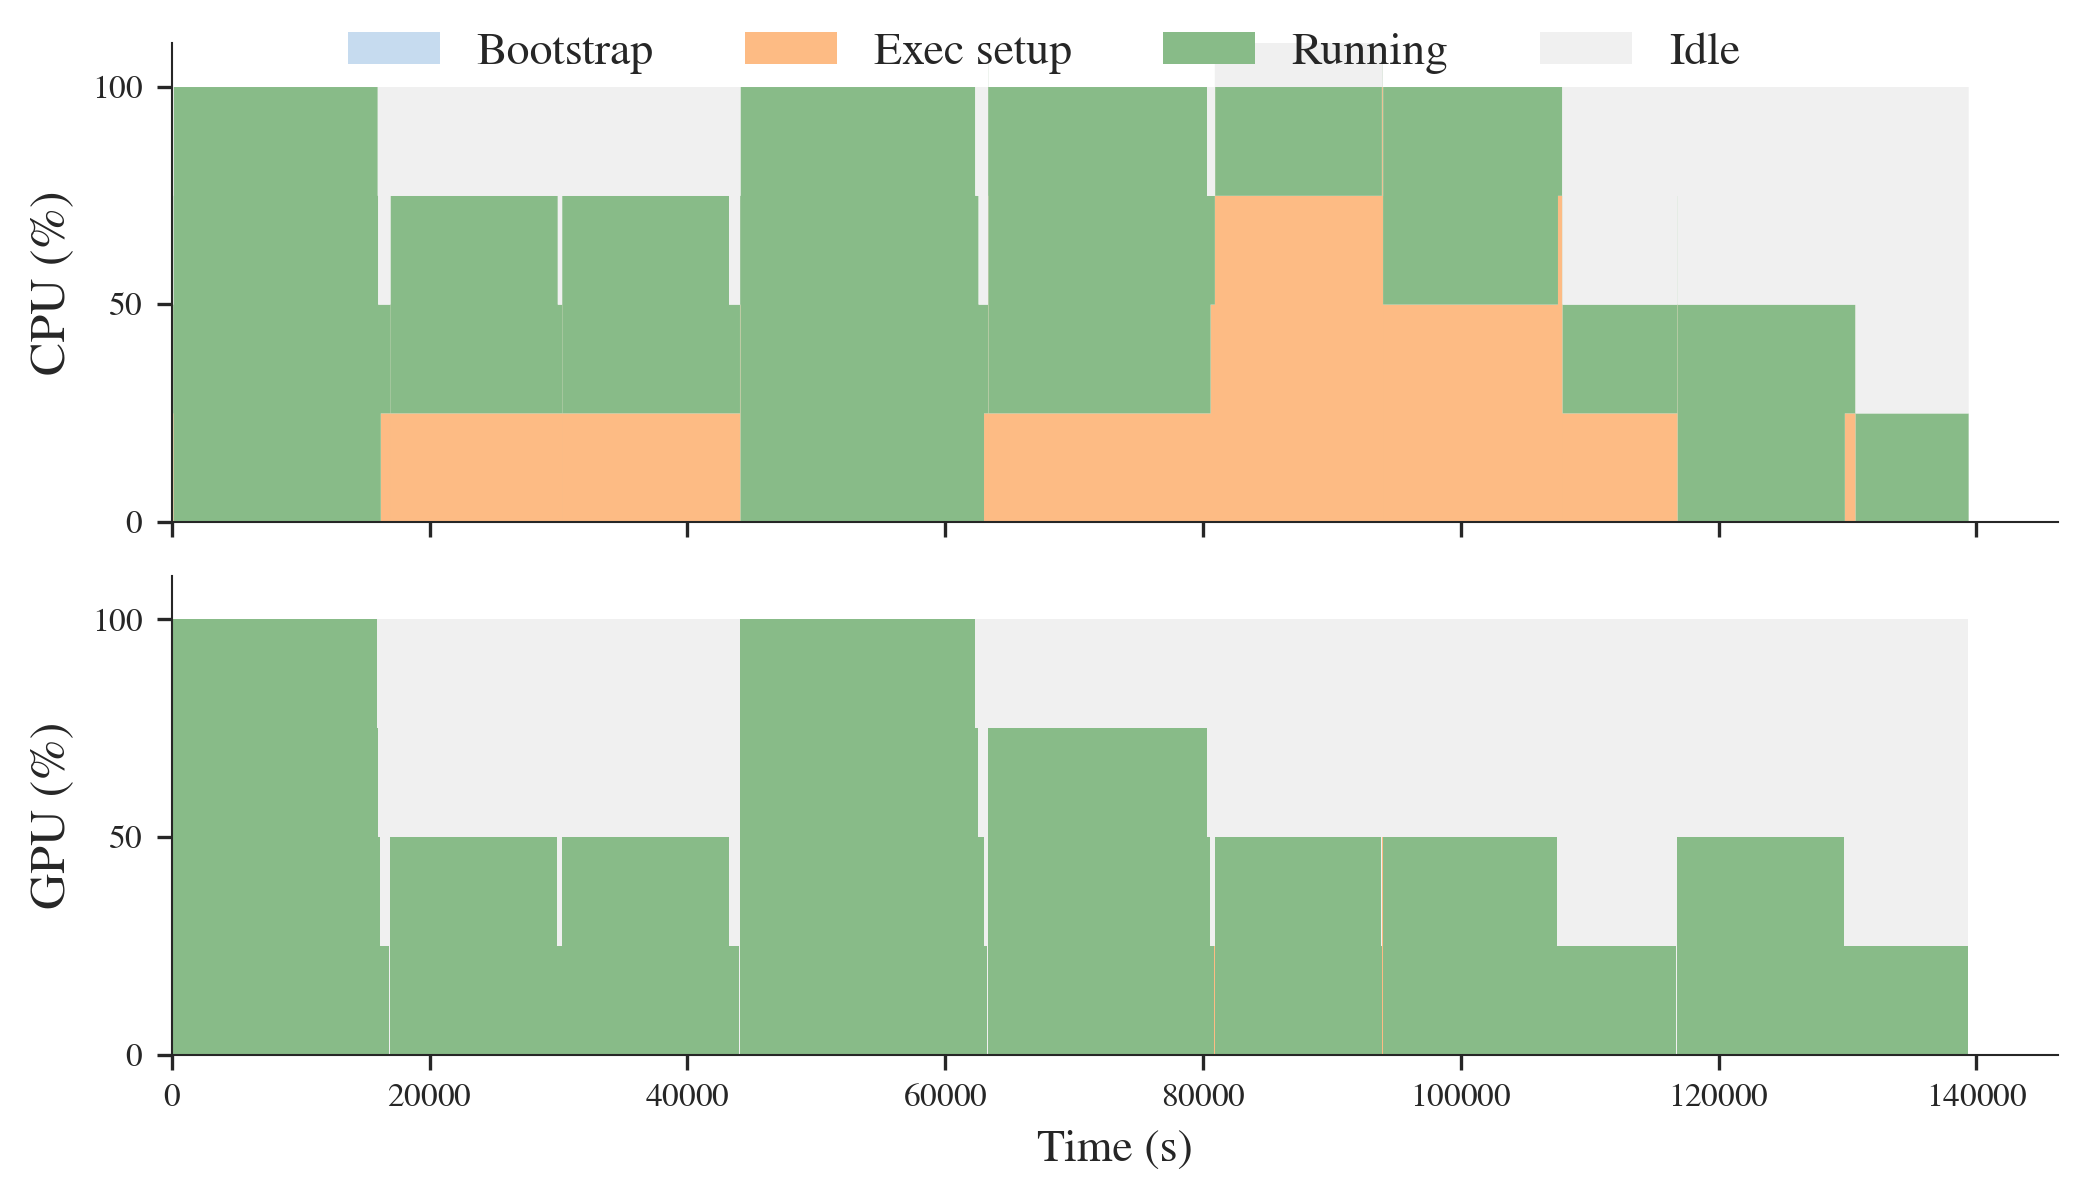

In [15]:
plot_utilization_stack(data, resources=['cpu', 'gpu'], save=True)

# Concurrency
Number of tasks within a certain phase during a runtime period.

/tmp/ipykernel_750422/2040727929.py:68: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(legend,
/tmp/ipykernel_750422/2040727929.py:76: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(legend,


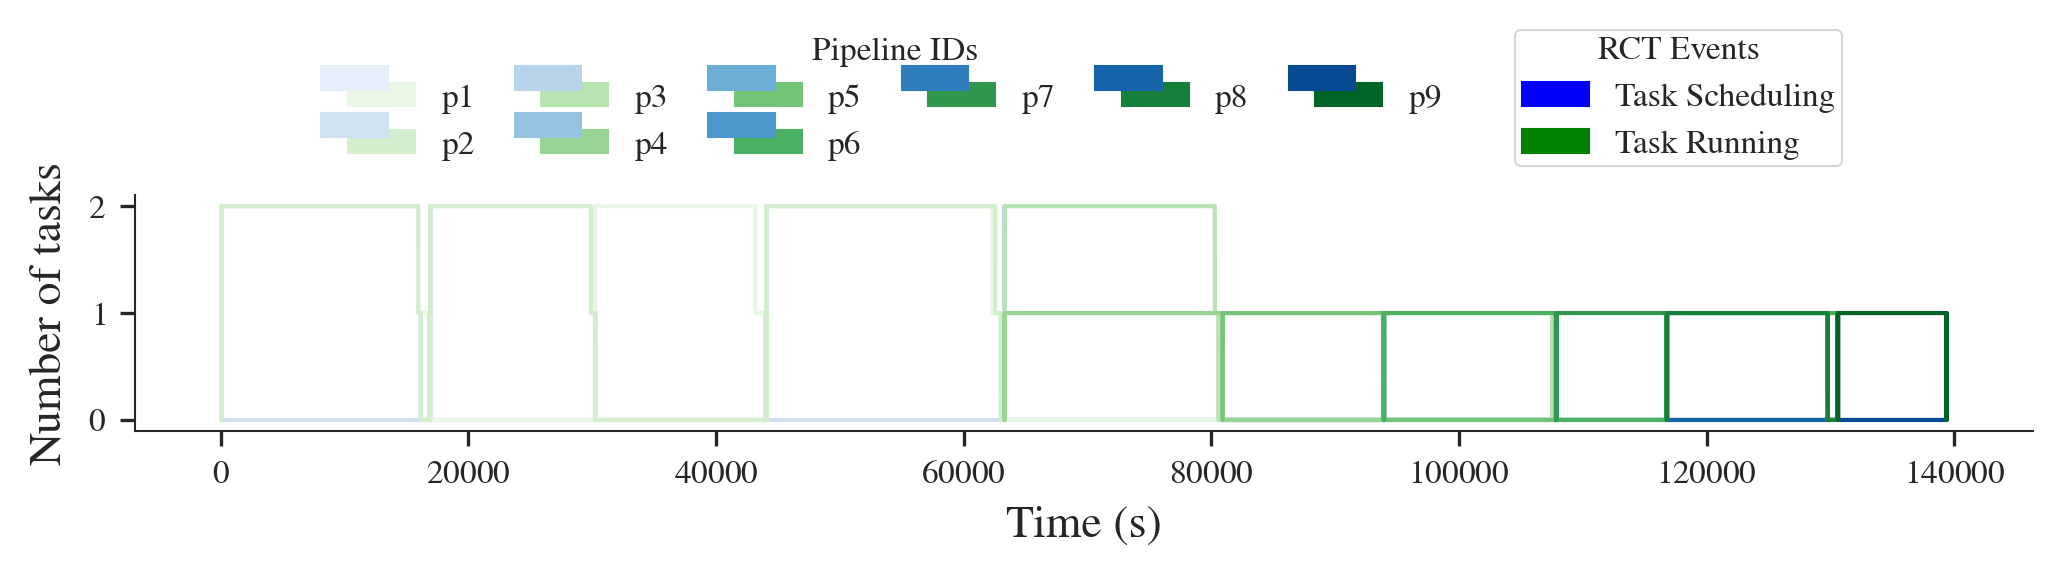

In [17]:
def plot_concurrency(data, save=False):

    events = {'Tasks scheduling': [{ru.STATE: 'AGENT_SCHEDULING'},
                                   {ru.EVENT: 'schedule_ok'}],
              'Tasks running'   : [{ru.EVENT: 'exec_start'},
                                   {ru.EVENT: 'exec_stop'}]}

    # events = {'Tasks placed'   : [{ru.EVENT: 'launch_submit'},
    #                               {ru.EVENT: 'launch_collect'}]}
    # events = {'Job steps launched': [{ru.EVENT: 'launch_submit'},
    #                                  {ru.EVENT: 'exec_start'}]}

    fig, ax = plt.subplots(1, 1, figsize=(7, 2))

    pilot_starttime = data['pilot'].\
        timestamps(event={ru.EVENT: 'bootstrap_0_start'})[0]

    legend = []
    sid = data['sid']
    pid = data['pid']

    p_tasks = {}  # tasks per pipeline
    for task in data['tasks'].get():
        pipeline_uid = task.description['uid'].split('.')[0]
        p_tasks.setdefault(pipeline_uid, []).append(task.uid)

    # green color with darker shades
    M_COLOR_RUNNING = generate_color_shades(len(p_tasks), base_color='Greens')
    M_COLOR_SCHEDULING = generate_color_shades(len(p_tasks), base_color='Blues')

    for e_name in events:
        # make sure to sort the p_tasks based on the pipeline id (i.e, ascending)
        p_tasks = {key: p_tasks[key] for key in sorted(p_tasks, key=lambda x: int(x[1:]))}
        for idx, (p_uid, task_uids) in enumerate(p_tasks.items()):
            p_session = data['session'].filter(uid=task_uids + [pid], inplace=False)
            
            time_series = p_session.concurrency(event=events[e_name], sampling=0.1)

            if e_name == 'Tasks scheduling':
                ax.plot([e[0] - pilot_starttime for e in time_series],
                        [e[1] for e in time_series],
                        label=ra.to_latex(e_name), lw=1, color=M_COLOR_SCHEDULING[idx])
            else:
                ax.plot([e[0] - pilot_starttime for e in time_series],
                        [e[1] for e in time_series],
                        label=ra.to_latex(e_name), lw=1, color=M_COLOR_RUNNING[idx])
        legend.append(e_name)

    ax.set_ylabel(to_latex('Number of tasks'), fontsize=11)
    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)
    
    legend_handles = [mpatches.Patch(color=M_COLOR_RUNNING[i], label=f"{task_id}") 
                      for i, task_id in enumerate(p_tasks.keys())]
    
    legend_handles2 = [mpatches.Patch(color=M_COLOR_SCHEDULING[i], label="    ") 
                      for i, task_id in enumerate(p_tasks.keys())]
    
    # Add the main plot legend (if needed)
    ax.legend(loc="upper left")
    
    # Add the secondary legend for the color-ID association
    secondary_legend = plt.legend(handles=legend_handles,
                                  title="Pipeline IDs",
                                  bbox_to_anchor=(0.1, 1.05), ncol=6, frameon=False)



    fig.legend(legend,
               handles=[mpatches.Patch(color='blue', label='Task Scheduling'),
                        mpatches.Patch(color='green', label='Task Running')],
               bbox_to_anchor=(0.9, 0.95),
               ncol=1,
               title="RCT Events",
               frameon=True)

    fig.legend(legend,
               handles=legend_handles2,
               bbox_to_anchor=(0.7, 0.9), ncol=6, frameon=False)#, handlelength=1)

    plt.tight_layout()
    plt.show()

    if save:
        plot_name = '%s.concurrency.png' % '.'.join(data['sid'].rsplit('.', 2)[1:])
        fig.savefig(os.path.join('.', plot_name))

plot_concurrency(data, save=True)